# 64 注意力机制

## 生物学中的注意力提示 -> 注意力机制

非自主性提示：客观世界中一些事物的固有属性比较“显眼”

自主性提示：主观意识想做

注意力机制：

- 键：非自主性提示，是世界中一些事物的客观属性，可以不同程度上“吸引”注意力，有的强，有的弱

- 查询：自主性提示，用来“筛”键，通过注意力汇聚，提取出键中受查询感兴趣的东西

- 值：感官输入，查询对键筛选出之后，结合k-v对得到一个综合的值，获得的实际感官输入

![](./assets/attention_1.jpg)

## 注意力的可视化

核心思路就是传入一个矩阵matrices，前两维表示横向/纵向有几张图，后两维表示每张图的某个查询对应某个键值的注意力值。

In [2]:
import torch
from d2l import torch as d2l

In [ ]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

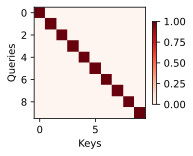

In [7]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## Nadaraya-Watson 核回归

### 生成数据集

根据$ y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon $生成数据集，其中$\epsilon$服从均值为0、方差为0.5的正态分布。

In [8]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

### 辅助绘图函数

以下函数绘制所有带噪声的样本点、真实的函数、预测的函数

In [9]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

### 平均汇聚

最简陋的算法，不考虑查询值，直接将所有样本的标签值求平均

$f(x)=\frac{1}{n}\sum_{i=1}^n y_i$

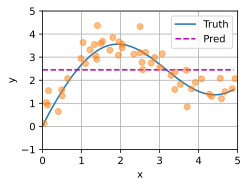

In [10]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 非参数注意力汇聚

$ f(x) = \sum_{i=1}^n \frac{K(x, x_i)}{\sum_{j=1}^n K(x, x_j)}y_i $

$ K(x, x_i) $ 是注意力核函数

这里x可以看作查询，x_i可以看作键，y_i可以看作值。

注意力机制的思想是，对于一个查询，我们可以根据其与一组键值对之间的注意力，来决定对查询的注意力。

非参数注意力机制的特点是，不需要学习参数，而是直接使用注意力核函数K(x, x_i)来计算注意力。